In [1]:
# Define a vector containing the names of all required packages that need to be installed or loaded
required_packages <- c("zipfR", "ggplot2", "stringr", "scales", "tibble", "dplyr", "gss")

# Iterate through each package in our defined list called 'required_packages'
for (pkg in required_packages) {
  # Check if the current package is already loaded
  if (!require(pkg, character.only = TRUE)) {
    # If not installed, install it including all its dependencies
    # This line installs packages that are missing or those with any version mismatch
    install.packages(pkg, dependencies = TRUE)

    # Load the newly installed package for use in our code
    library(pkg, character.only = TRUE)
  }
}

Loading required package: zipfR

Loading required package: ggplot2

Loading required package: stringr

Loading required package: scales

Loading required package: tibble

Loading required package: dplyr


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: gss



In [2]:
# Sets the path of the folder that contains files which will be processed.
folder_path <- "output_txt_files"

# Utilizes 'list.files' function to identify all '.txt' files within the specified folder and returns their full paths as a character vector.
files <- list.files(folder_path, pattern = "\\.txt$", full.names = TRUE)


In [3]:
# Initialize an empty data frame to store our results. The columns will be 'File', 'Type', 'Model',
# 'Rank', and 'Frequency'.
results <- data.frame(File = character(), Type = character(), Model = character(),
                     Rank = numeric(), Frequency = numeric())

# Iterate over each file specified in the `files` variable.
for (file in files) {

  # Read the content of the current file, converting everything to lowercase for easier comparison,
  # and split it into individual words. We remove any empty strings that may result from this process.
  text <- tolower(readLines(file, warn = FALSE))
  text <- unlist(strsplit(text, "\\W+"))

  # Calculate the frequency of each word in the file's content using `table()`, sort them
  # in decreasing order, and store the result as a vector. The words with higher frequencies will appear first.
  freq <- table(text)
  freq <- sort(freq, decreasing = TRUE)

  # Extract the necessary information from the filename for our results column (File Name, Type of data,
  # Model name). This is done using regular expression matching on `basename(file)`.
  file_info <- str_match(basename(file), "(.*) (.*)\\d_responses.txt")

  # Ensure that the file name follows a specific format for us to extract information correctly.
  if (length(file_info) < 3) {
    next
  } else {
  model <- file_info[2]
  type <- file_info[3]
}

  # Create a temporary data frame containing the extracted results: File Name, Type of data,
  # Model name, rank (which is simply the index in our sorted frequency vector), and their corresponding frequencies.
  temp_df <- data.frame(File = basename(file),
                        Type = type,
                        Model = model,
                        Rank = 1:length(freq),
                        Frequency = as.numeric(freq))

  # Combine this temporary results frame with our overall `results` data frame using `rbind()`.
  results <- rbind(results, temp_df)
}

# Print out the final results data frame.
  print(results)

                                 File     Type    Model Rank Frequency
1    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    1       157
2    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    2        94
3    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    3        77
4    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    4        65
5    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    5        58
6    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    6        47
7    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    7        41
8    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    8        37
9    Deepseek 创意写作1_responses.txt 创意写作 Deepseek    9        35
10   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   10        31
11   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   11        29
12   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   12        27
13   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   13        26
14   Deepseek 创意写作1_responses.txt 创意写作 Deepseek   14        23
15   Deepseek 创意写作1_responses.txt 创意写作 Deepseek

In [4]:
# Load necessary libraries
library(zipfR)

# Initialize a list to store fitting results
fit_results <- list()

# Loop through each unique file in the dataset for Zipf-Mandelbrot fitting
for (file in unique(results$File)) {
  # Extract data related to this file
  data <- subset(results, File == file)

  # Print extracted data
  print(data)

  # Confirm correct column names
  print(colnames(data))

  # Inspect the structure of the dataset for further processing

  # Prepare parameters needed for spc function call
  N <- sum(data$Frequency)  # Sample size
  V <- length(data$Frequency)  # Length of frequency vector
  Vm <- table(data$Frequency)  # Number of types with frequency as m
  m <- as.numeric(names(Vm))  # Frequencies

  # Attempt to call the spc function and handle any potential errors
  fit <- tryCatch({
    spc(N = N, V = V, Vm = as.numeric(Vm), m = m)
  }, error = function(e) {
    print(paste("Error in spc function:", e))
    # Store null if there is an error to avoid stopping the execution
    NULL
  })

  # Print result from the spc function call (if successful)
  print(fit)

  # Store fitting results for this file in a list structure
  fit_results[[file]] <- fit
}

# Print final list of all fitting results across files
print(fit_results)


                                File     Type    Model Rank Frequency
1   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    1       157
2   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    2        94
3   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    3        77
4   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    4        65
5   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    5        58
6   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    6        47
7   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    7        41
8   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    8        37
9   Deepseek 创意写作1_responses.txt 创意写作 Deepseek    9        35
10  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   10        31
11  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   11        29
12  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   12        27
13  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   13        26
14  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   14        23
15  Deepseek 创意写作1_responses.txt 创意写作 Deepseek   15        22


`geom_smooth()` using formula = 'y ~ x'


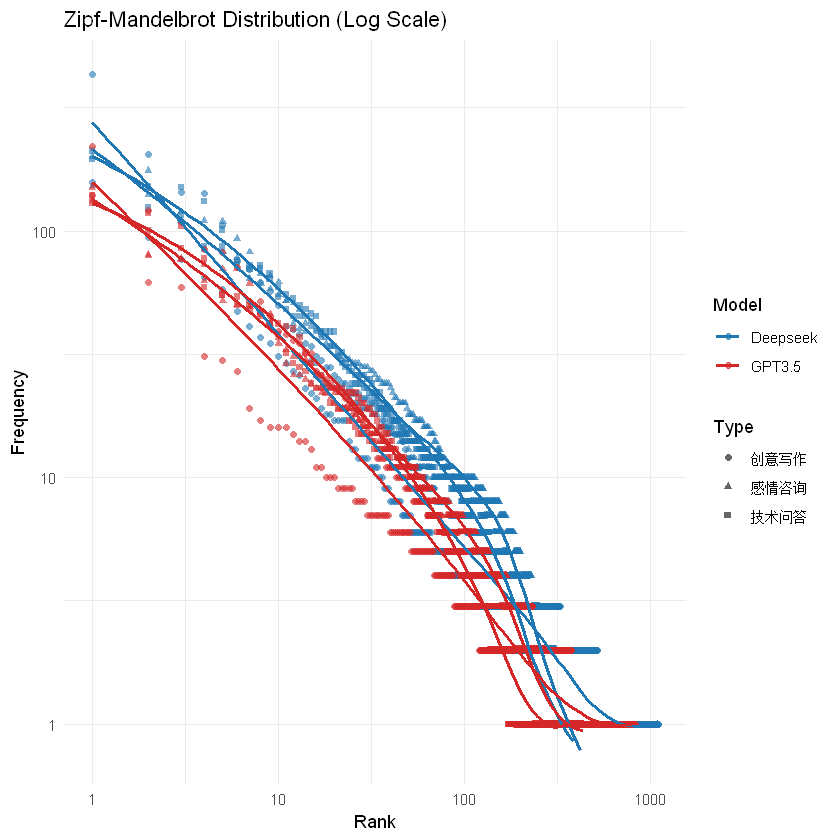

In [7]:
# Set up custom color scheme for models
model_colors <- c("Deepseek" = "#1f77b4",
                  "Model2" = "#2ca02c",
                  "GPT3.5" = "#d62728")

# Initialize ggplot object with data, mapping 'Rank' to x-axis and 'Frequency' to y-axis
ggplot(results, aes(x = Rank, y = Frequency, color = Model, shape = Type)) +

  # Add geometric layer for points and set alpha level for transparency
  geom_point(alpha = 0.6) +

  # Add a smooth curve without standard error
  geom_smooth(se = FALSE, method = "loess") +

  # Customize the color scale using defined `model_colors`
  scale_color_manual(values = model_colors) +

  # Set title for plot with centered alignment
  labs(title = "Zipf-Mandelbrot Distribution (Log Scale)",
       x = "Rank", y = "Frequency") +

  # Choose minimal theme style for cleaner appearance
  theme_minimal() +

  # Adjust legend position to the right side of the plot
  theme(legend.position = "right") +

  # Apply logarithmic scale transformation to both axes for better visualization of distribution data
  scale_x_log10() +
  scale_y_log10()


`geom_smooth()` using formula = 'y ~ x'


ERROR: [1m[33mError[39m:[22m
[1m[22m[33m![39m Cannot add [34m<ggproto>[39m objects together.
[36mℹ[39m Did you forget to add this object to a [34m<ggplot>[39m object?


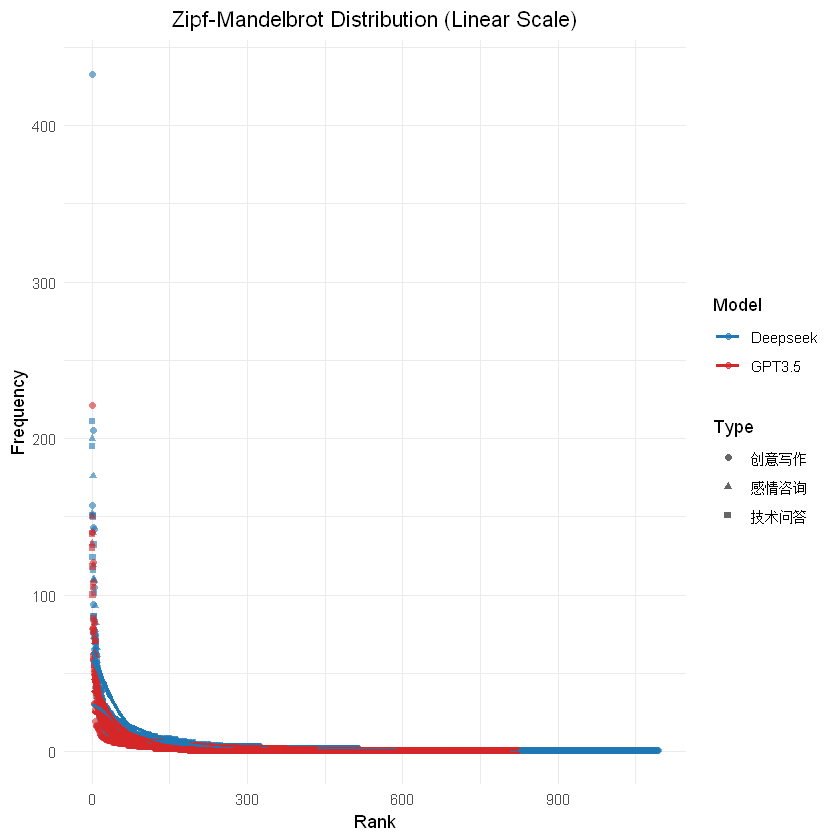

In [8]:
# Define a color palette using named colors for different models
model_colors <- c("Deepseek" = "#1f77b4",
                  "Model2" = "#2ca02c",
                  "GPT3.5" = "#d62728") # Example colors

# Create the plot with provided data and aesthetics settings for points, color, shape, and smooth curves
ggplot(results, aes(x = Rank, y = Frequency, color = Model, shape = Type)) +
  geom_point(alpha = 0.6) + # Use alpha parameter to make points more transparent
  geom_smooth(se = FALSE, method = "loess") + # Add a smoothed curve using LOESS method
  scale_color_manual(values = model_colors) + # Manually set color palette
  labs(title = "Zipf-Mandelbrot Distribution (Linear Scale)", x = "Rank", y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5), # Center the title
        legend.position = "right") # Place the legend on the right side of the plot
  scale_x_continuous(limits = c(min(results$Rank), max(results$Rank))) + # Set minimum and maximum limits for x-axis range
  scale_y_continuous(limits = c(min(results$Frequency), max(results$Frequency))) # Set minimum and maximum limits for y-axis range


In [9]:
# Ensure that the 'Rank' and 'Frequency' columns are numeric, which means they contain numerical values.
results$Rank <- as.numeric(as.character(results$Rank))
results$Frequency <- as.numeric(as.character(results$Frequency))

# Transform 'Model' and 'Type' columns into factor type to properly handle categorical data during analysis.
# Factor types allow R to understand the data is not continuous but has specific, discrete categories.
results$Model <- as.factor(results$Model)
results$Type <- as.factor(results$Type)

# Utilize the 'ssanova' function from the 'gss' package for a Type III ANOVA analysis. This function helps break down variance in a response variable across multiple factors and their interactions.
library(gss) # Load the gss library to access the ssanova function

# Apply ssanova to analyze 'Frequency' as a dependent variable with 'Rank', 'Model', and 'Type' as independent variables including their potential interactions.
# This will help understand if there are significant differences in frequency based on each factor or combination of factors.
ssanova_results <- ssanova(Frequency ~ Rank * Model * Type, data = results)

# Display the analysis output to see the results of the ANOVA test
print(ssanova_results)



Call:
ssanova(formula = Frequency ~ Rank * Model * Type, data = results)

Terms:
[1] "1"               "Rank"            "Model"           "Type"           
[5] "Rank:Model"      "Rank:Type"       "Model:Type"      "Rank:Model:Type"

Number of unpenalized and penalized terms:

                Unpenalized Penalized
1                         1         0
Rank                      1         1
Model                     1         0
Type                      0         1
Rank:Model                1         1
Rank:Type                 0         2
Model:Type                0         1
Rank:Model:Type           0         2
total                     4         8

Smoothing parameters are selected by GCV with alpha=1.4.
